# Novel View Synthesis

The task consists of building a neural model capable of generating new views of an object from different angles, based on a limited set of input images. The goal is to synthesize novel viewpoints of a 3D scene using only 2D images. The dataset used in this project is the [NeRF Synthetic Dataset](https://www.kaggle.com/datasets/sauravmaheshkar/nerf-dataset?resource=download).

Each object in the dataset is represented by a collection of RGB images captured from different
camera positions, and the camera pose is provided for each image.

The dataset structure is as follows:
```
├── nerf_synthetic
│   ├── SCENE_NAME
│   │   ├── train
│   │   │   ├── r_0.png
│   │   │   ├── r_1.png
│   │   ├── val
│   │   │   ├── r_0.png
│   │   │   ├── r_1.png
│   │   ├── test
│   │   │   ├── r_0.png
│   │   │   ├── r_1.png
│   │   │   ├── r_0_depth_0000.png
│   │   │   ├── r_1_depth_0000.png
│   │   │   ├── r_0_normal_0000.png
│   │   │   ├── r_1_normal_0000.png
│   │   ├── transforms_train.json
│   │   ├── transforms_val.json
│   │   ├── transforms_test.json

```

# Downloading the data

In [1]:
import os
import gdown
import numpy as np
import matplotlib.pyplot as plt

The dataset used in this project is from Cornell University.

In [2]:
url = "https://drive.google.com/uc?id=1_XlQ2tGZOy_lEBT6Pg_ciFmn34TljTp4"
if not os.path.exists("data/lego_200x200.npz"):
    gdown.download(url, "lego_200x200.npz")

# Task overview

The model used for Novel View Synthesis is typically a neural network that learns a mapping from the 2D image space to a 3D representation of the scene. One popular approach is Neural Radiance Fields (NeRF).

In [3]:
def preprocess_data(images, poses):
    images_normalized = images.astype(np.float32) / 255.0

    transform = np.diag([1, -1, -1, 1])
    poses_transformed = poses @ transform
    poses_transformed = poses_transformed.astype(np.float32)

    return images_normalized, poses_transformed

In [4]:
dataset = np.load("data/lego_200x200.npz")

images_train = dataset["images_train"]
images_val = dataset["images_val"]
c2ws_train = dataset["c2ws_train"]
c2ws_val = dataset["c2ws_val"]
c2ws_test = dataset["c2ws_test"]
focal = dataset["focal"]

images_train, c2ws_train = preprocess_data(images_train, c2ws_train)
images_val, c2ws_val = preprocess_data(images_val, c2ws_val)
_, c2ws_test = preprocess_data(images_val, c2ws_test)

Images shape: (100, 200, 200, 3)
Poses shape: (100, 4, 4)
Focal length: 277.77775779844205


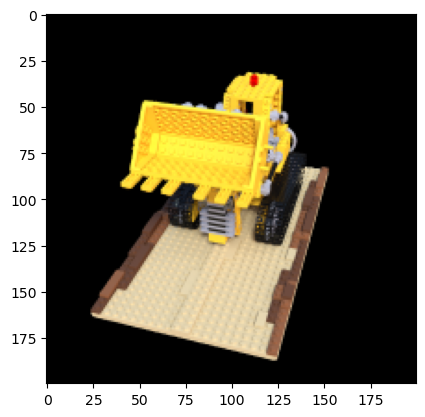

In [5]:
print(f"Images shape: {images_train.shape}")
print(f"Poses shape: {c2ws_train.shape}")
print(f"Focal length: {focal}")

H, W = images_train.shape[1:3]
t_n, t_f = 2.0, 6.0

test_idx = 1
test_img, test_pose = images_val[test_idx], c2ws_val[test_idx]

plt.imshow(test_img)
plt.show()

# Metrics

The main metric for this task is Peak Signal-to-Noise Ratio (PSNR), which measures the structural similarity between the predicted and target image. A higher PSNR score indicates better reconstruction quality, with a value over 20 being indicative of a well-converged model. Additionally, the model is expected to produce a reasonable depth map as a side output of the novel view synthesis process.

Here's the function to compute PSNR:

In [6]:
def compute_psnr(y_true, y_pred):
    psnr = -10.0 * np.log10(np.mean((y_true - y_pred) ** 2))
    return psnr

## My solution

The NeRF pipeline consists of the following steps:

1. Ray generation: Given an image of size $H \times W$ and the camera parameters, we compute a ray for each pixel. This ray originates from the camera and passes through the corresponding pixel.
2. Ray marching: For each ray, we select $N_c$ points between $t_{n}$ and $t_{f}$. These points are then expressed as $(x, y, z)$ coordinates.
3. NeRF query: We pass the $(x, y, z)$ coordinates to a Multi-Layer Perceptron (MLP) network, which returns the $(r, g, b)$ color and the density $\sigma$ for each point.
4. Volume rendering: We integrate along the ray using volume rendering, combining density and color values to obtain the final pixel color.
5. Optimization: We compare the rendered image with the ground truth image, compute the loss, and update the neural network accordingly.

In [7]:
import time
import imageio
import tensorflow as tf

from tqdm import tqdm
from PIL import Image
from IPython.display import Video

2025-05-23 10:09:44.613250: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 10:09:44.704745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-23 10:09:44.725116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-23 10:09:44.729881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 10:09:44.818869: I tensorflow/core/platform/cpu_feature_guar

In [8]:
# For repeatability
seed = 17
np.random.seed(seed)
tf.random.set_seed(seed)

We have multiple images captured from a camera positioned at different locations. For each camera, we are given a $4 \times 4$ matrix, that describes its position and orientation. This matrix is written as:

$$ c2w = \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} $$

where:
- $R$ is a rotation matrix representing the camera's orientation in the world.
- $t$ is a translation vector representing the camera's position in the world.

By multiplying a point in camera space by this matrix, we obtain the corresponding point in world space. For this reason, this transformation matrix is called camera-to-world (c2w).

![Perspective projection geometry](assets/perspective_projection_geometry.png)

We assume a pinhole camera model, where all rays originate from a single point (the camera center) and pass through the image plane in front of the camera.

To implement this, we create a grid of pixel coordinates $(i,j)$ and compute the corresponding ray directions in camera space. Pixel coordinates are defined in image space, with $(0, 0)$ at the top-left and $(W - 1, H - 1)$ at the bottom-right. In camera space, we shift the origin to the image center $(0, 0)$ in the X-Y plane. We then transform ray directions to world space using the rotation matrix $R$ from `c2w` and extract ray origins from its last column, which contains the camera position $t$. Since we use a pinhole model, all rays originate from the camera center.

In [ ]:
def get_rays(H, W, f, c2w):
    """Compute ray origins and directions in world coordinates."""
    i, j = tf.meshgrid(
        tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing="xy"
    )

    dirs = tf.stack(
        [(i - W * 0.5) / f, -(j - H * 0.5) / f, -tf.ones_like(i)], axis=-1  # x  # y
    )

    R = c2w[:3, :3]
    t = c2w[:3, -1]

    rays_d = tf.reduce_sum(dirs[..., tf.newaxis, :] * R, axis=-1)
    rays_o = tf.broadcast_to(t, tf.shape(rays_d))

    return rays_o, rays_d

NeRF trains using 3D query points sampled along rays. The `sample_stratified` function generates `N_c` values uniformly between 0 and 1, mapping them to depth values via linear interpolation. The corresponding 3D points are then computed as:

$$ \mathbf{r}(t) = \mathbf{o} + t \cdot \mathbf{d} $$ 

where $\mathbf{o}$ is the ray origin, $\mathbf{d}$ its direction, and $t$ the depth. The result is a tensor `pts` of shape `[N_rays, N_c, 3]`, representing sampled 3D coordinates along each ray.

In [ ]:
def sample_stratified(rays_o, rays_d, t_n, t_f, N_rays, N_c, perturb=0):
    """Stratified sampling along rays."""
    t_vals = tf.linspace(0.0, 1.0, N_c)
    t_i = t_n * (1.0 - t_vals) + t_f * t_vals
    t_i = tf.broadcast_to(t_i, [N_rays, N_c])  # (N_rays, N_c)

    if perturb:
        mids = 0.5 * (t_i[..., 1:] + t_i[..., :-1])
        lower = tf.concat([t_i[..., :1], mids], axis=-1)
        upper = tf.concat([mids, t_i[..., -1:]], axis=-1)
        t_rand = tf.random.uniform(t_i.shape)
        t_i = lower + (upper - lower) * t_rand

    pts = rays_o[..., None, :] + rays_d[..., None, :] * t_i[..., :, None]
    return pts, t_i

NeRF improves high-frequency detail representation with positional encoding, mapping 3D coordinates $(x, y, z)$ into a higher-dimensional space using sinusoidal functions: 

$$ \gamma (p) = (\sin(2^0 \pi p), \cos(2^0 \pi p), \ldots, \sin(2^{L-1} \pi p), \cos(2^{L-1} \pi p)) $$

In [ ]:
def get_positional_encoder(L, input_dims=3):
    """Create positional encoding function."""
    freq_bands = 2.0 ** tf.linspace(0.0, L - 1, L)
    out_dims = input_dims * (1 + 2 * L)

    def gamma(x):
        gamma_terms = [x]
        for freq in freq_bands:
            gamma_terms.append(tf.sin(x * freq))
            gamma_terms.append(tf.cos(x * freq))
        return tf.concat(gamma_terms, axis=-1)

    return gamma, out_dims

The NeRF model has the following structure:

![Nerf Architecture](assets/nerf_architecture.png)

In [ ]:
def init_nerf_model(D=8, W=256, input_dims_pos=3, input_dims_dir=3, skips=[4]):
    """Initialize a NeRF MLP model."""
    inputs = tf.keras.Input(shape=(input_dims_pos + input_dims_dir,))
    x_encoded = inputs[..., :input_dims_pos]
    d_encoded = inputs[..., input_dims_pos:]

    x = x_encoded
    for i in range(D):
        x = tf.keras.layers.Dense(W, activation="relu")(x)
        if i in skips:
            x = tf.keras.layers.Concatenate()([x, x_encoded])

    sigma = tf.keras.layers.Dense(1)(x)
    bottleneck = tf.keras.layers.Dense(W)(x)

    x = tf.keras.layers.Concatenate()([bottleneck, d_encoded])
    x = tf.keras.layers.Dense(W // 2, activation="relu")(x)
    rgb = tf.keras.layers.Dense(3)(x)

    outputs = tf.keras.layers.Concatenate()([rgb, sigma])
    return tf.keras.Model(inputs=inputs, outputs=outputs)

We convert the neural network’s raw output into images using volume rendering, following Sec. 4 of the [paper](https://arxiv.org/pdf/2003.08934). The NeRF MLP outputs color ($\mathbf{c}$) and density ($\sigma$) for each sampled point along a ray. The final color is estimated as:

$$ \hat{C}(\mathbf{r}) = \sum_{i=1}^N T_i  (1 - \exp(- \sigma_i \delta_i)) \mathbf{c}_i $$

where  $N$ is the number of samples, and $\delta_i$ is the 3D distance between consecutive points, corrected for direction length.  A value of $10^{10}$ is appended for the last sample to approximate infinity. Color values are unconstrained, so we apply a sigmoid function to map them to $[0,1]$. Density values determine the $\alpha$ (transmittance), computed as:

$$ \alpha_i = 1 - e^{(-\sigma_i \cdot d_i)} $$

To ensure non-negative density, we use ReLU. The contribution of each sample to the final color is given by:

$$ w_i = \alpha_i \cdot \prod_{j=1}^{i-1} (1 - \alpha_j) $$

where the cumulative product represents light transmission. The final image color is a weighted sum of sample colors, with denser points absorbing more light.

In [ ]:
def volumetric_rendering(raw, t_i, rays_d):
    """Perform volume rendering from raw model outputs."""
    delta_i = t_i[..., 1:] - t_i[..., :-1]
    delta_i = tf.concat(
        [delta_i, tf.broadcast_to([1e10], delta_i[..., :1].shape)], axis=-1
    )
    delta_i *= tf.norm(rays_d[..., None, :], axis=-1)

    sigma = tf.nn.relu(raw[..., 3])
    c = tf.sigmoid(raw[..., :3])

    alpha_i = 1.0 - tf.exp(-sigma * delta_i)
    T_i = tf.math.cumprod(1.0 - alpha_i + 1e-10, axis=-1, exclusive=True)
    w_i = alpha_i * T_i

    C_hat = tf.reduce_sum(w_i[..., None] * c, axis=-2)
    depth = tf.reduce_sum(w_i * t_i, axis=-1)

    return C_hat, w_i, depth

The paper introduces *hierarchical sampling* to reduce queries for high-frequency representations. Uniform sampling is inefficient, as it includes irrelevant regions. To improve this, a *coarse* and *fine* network are optimized together. First, $N_c$ points are sampled via *stratified sampling*. The *coarse* network's output is used to normalize weights and compute a PDF along the ray, guiding the sampling of $N_f$ additional points.

In [ ]:
def sample_pdf(bins, weights, N_f):
    """Perform volume rendering from raw model outputs."""
    weights += 1e-5
    pdf = weights / tf.reduce_sum(weights, axis=-1, keepdims=True)
    cdf = tf.cumsum(pdf, axis=-1)
    cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], axis=-1)

    u = tf.random.uniform(list(cdf.shape[:-1]) + [N_f])

    inds = tf.searchsorted(cdf, u, side="right")
    below = tf.maximum(0, inds - 1)
    above = tf.minimum(cdf.shape[-1] - 1, inds)

    inds_g = tf.stack([below, above], axis=-1)
    cdf_g = tf.gather(cdf, inds_g, axis=-1, batch_dims=len(inds_g.shape) - 2)
    bins_g = tf.gather(bins, inds_g, axis=-1, batch_dims=len(inds_g.shape) - 2)

    denom = cdf_g[..., 1] - cdf_g[..., 0]
    denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples

In [ ]:
def sample_hierarchical(rays_o, rays_d, t_vals, weights, N_f):
    """Perform hierarchical sampling based on weights from coarse network."""
    t_mid = 0.5 * (t_vals[..., 1:] + t_vals[..., :-1])
    new_t = sample_pdf(t_mid, weights[..., 1:-1], N_f)
    new_t = tf.stop_gradient(new_t)

    t_combined = tf.sort(tf.concat([t_vals, new_t], axis=-1), axis=-1)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * t_combined[..., :, None]
    return pts, t_combined

In [ ]:
def batchify(fn, chunk):
    """Apply a function in chunks to avoid OOM errors."""
    return lambda inputs: tf.concat(
        [fn(inputs[i : i + chunk]) for i in range(0, inputs.shape[0], chunk)], axis=0
    )


def encode_positions(x, gamma_fn):
    x_flat = tf.reshape(x, [-1, x.shape[-1]])
    x_encoded = gamma_fn(x_flat)
    return x_encoded


def encode_directions(x, d, gamma_fn):
    d_broadcast = tf.broadcast_to(d[:, None], x.shape)
    d_flat = tf.reshape(d_broadcast, [-1, d_broadcast.shape[-1]])
    d_encoded = gamma_fn(d_flat)
    return d_encoded


def network_query_fn(
    network, positions, view_directions, netchunk, encode_pos_fn, encode_dir_fn
):
    encoded_positions = encode_positions(positions, encode_pos_fn)
    encoded_directions = encode_directions(positions, view_directions, encode_dir_fn)
    encoded_inputs = tf.concat([encoded_positions, encoded_directions], axis=-1)

    outputs_flat = batchify(network, netchunk)(encoded_inputs)
    raw = tf.reshape(
        outputs_flat, list(positions.shape[:-1]) + [outputs_flat.shape[-1]]
    )
    return raw

In [ ]:
def render_rays(
    network_coarse,
    ray_batch,
    t_n,
    t_f,
    N_c,
    netchunk,
    encode_pos_fn,
    encode_dir_fn,
    network_fine,
    N_f,
    perturb=0,
):
    """Render rays with coarse and optionally fine network."""
    rays_o, rays_d = ray_batch[..., :3], ray_batch[..., 3:6]
    view_directions = ray_batch[:, -3:]
    N_rays = ray_batch.shape[0]

    # Compute 3D query points
    positions, t_vals = sample_stratified(
        rays_o, rays_d, t_n, t_f, N_rays, N_c, perturb
    )
    raw = network_query_fn(
        network_coarse,
        positions,
        view_directions,
        netchunk,
        encode_pos_fn,
        encode_dir_fn,
    )
    rgb_map, weights, depth_map = volumetric_rendering(raw, t_vals, rays_d)

    if N_f > 0:
        rgb_map_coarse = rgb_map
        positions, t_vals_combined = sample_hierarchical(
            rays_o, rays_d, t_vals, weights, N_f
        )
        raw = network_query_fn(
            network_fine,
            positions,
            view_directions,
            netchunk,
            encode_pos_fn,
            encode_dir_fn,
        )
        rgb_map, weights, depth_map = volumetric_rendering(raw, t_vals_combined, rays_d)

    ret = {"rgb_map": rgb_map, "depth_map": depth_map}
    if N_f > 0:
        ret["rgb_map_coarse"] = rgb_map_coarse
    return ret

In [ ]:
def batchify_rays(ray_batch, chunk, **kwargs):
    all_ret = {}
    for i in range(0, ray_batch.shape[0], chunk):
        ret = render_rays(ray_batch=ray_batch[i : i + chunk], **kwargs)
        for k, v in ret.items():
            all_ret.setdefault(k, []).append(v)

    all_ret = {k: tf.concat(v, axis=0) for k, v in all_ret.items()}
    return all_ret

In [ ]:
def render(rays, **kwargs):
    rays_o, rays_d = rays
    sh = rays_d.shape
    view_directions = rays_d / tf.linalg.norm(rays_d, axis=-1, keepdims=True)

    # Create ray batch
    ray_batch = tf.concat([rays_o, rays_d, view_directions], axis=-1)
    ray_batch = tf.reshape(ray_batch, [-1, 9])

    all_ret = batchify_rays(ray_batch, **kwargs)

    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = tf.reshape(all_ret[k], k_sh)

    k_extract = ["rgb_map"]
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k: all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]

In [20]:
def sample_random_rays(rays_o, rays_d, target, N_rand):
    coords = tf.stack(tf.meshgrid(tf.range(H), tf.range(W), indexing="ij"), -1)
    coords = tf.reshape(coords, [-1, 2])
    select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)
    select_inds = tf.gather_nd(coords, select_inds[:, tf.newaxis])
    rays_o = tf.gather_nd(rays_o, select_inds)
    rays_d = tf.gather_nd(rays_d, select_inds)
    batch_rays = tf.stack([rays_o, rays_d], axis=0)
    target_s = tf.gather_nd(target, select_inds)
    return batch_rays, target_s

## Hyperparameters

In [ ]:
L_pos = 10  # Frequency bands for position
L_dir = 4  # Frequency bands for direction
N_c = 64  # Coerse samples
N_f = 0  # Fine samples
net_width = 256  # Network width
net_depth = 8  # Network depth
skips = [4]  # Skip connections
t_n, t_f = 2.0, 6.0  # Near/far bounds
N_iters = 50000  # Number of iterations
N_rand = 32 * 32 * 2  # Random rays per batch
chunk = 1024 * 32  # Number of rays per chunk
network_chunk = 1024 * 32  # Number of rays per chunk for network
i_test = 100  # Test every i_test iterations
i_display = 2500  # Display every i_display iterations

We use the Adam optimizer with an initial learning rate of $5 \times 10^{-4}$, decaying exponentially to $5 \times 10^{-5}$. Other hyperparameters follow default values: $ \beta_1 = 0.9 $, $ \beta_2 = 0.999 $, and $ \epsilon = 10^{-7} $.

In [ ]:
initial_lr = 5e-4
lr_decay_steps = 10
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=lr_decay_steps * 1000,  # 10k steps per decay, but iters are 50k?
    alpha=0.1,
)

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

I0000 00:00:1747987824.793163 3041512 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747987824.992151 3041512 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747987824.992687 3041512 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747987824.997359 3041512 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [26]:
encode_pos_fn, input_dims_pos = get_positional_encoder(L_pos)
encode_dir_fn, input_dims_dir = get_positional_encoder(L_dir)

In [ ]:
model_coarse = init_nerf_model(
    D=net_depth,
    W=net_width,
    input_dims_pos=input_dims_pos,
    input_dims_dir=input_dims_dir,
    skips=skips,
)
model_fine = init_nerf_model(
    D=net_depth,
    W=net_width,
    input_dims_pos=input_dims_pos,
    input_dims_dir=input_dims_dir,
    skips=skips,
)

params = model_coarse.trainable_variables
if model_fine:
    params += model_fine.trainable_variables

In [28]:
model_coarse.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 90)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 63)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     16,384 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 319)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     81,920 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     65,792 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     65,792 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 27)        │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 283)       │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     36,352 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 3)         │        387 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        257 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 4)         │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 595,844 (2.27 MB)

 Trainable params: 595,844 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
kwargs = {
    "network_coarse": model_coarse,
    "t_n": t_n,
    "t_f": t_f,
    "N_c": N_c,
    "chunk": chunk,
    "netchunk": network_chunk,
    "encode_pos_fn": encode_pos_fn,
    "encode_dir_fn": encode_dir_fn,
    "network_fine": model_fine,
    "N_f": N_f,
}

kwargs_test = {k: kwargs[k] for k in kwargs}
kwargs_test["perturb"] = False

0 0.0004051182746887207 secs per iter
PSNR: 7.5367446


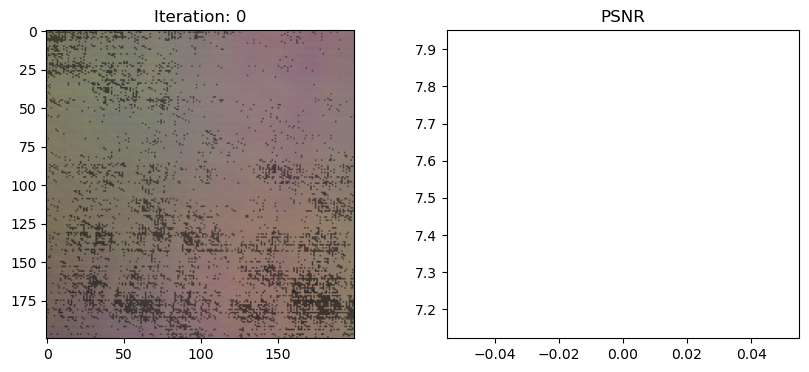

2500 0.06540693578720093 secs per iter
PSNR: 24.737228


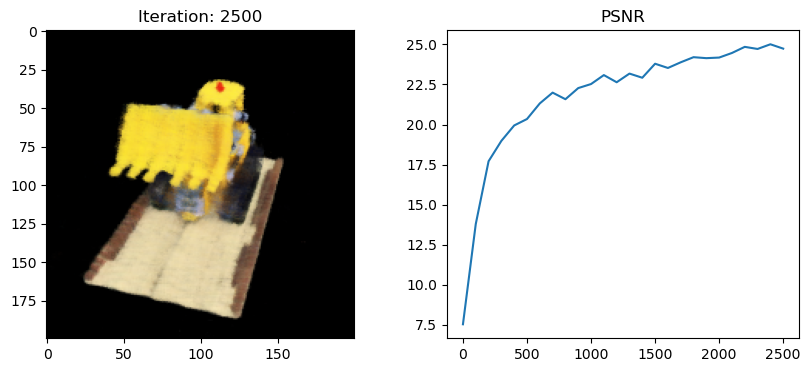

5000 0.06604456729888916 secs per iter
PSNR: 25.721075


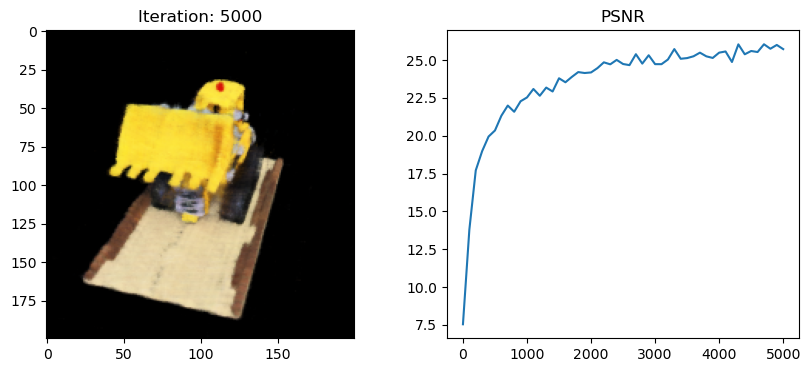

7500 0.06606982879638672 secs per iter
PSNR: 26.541616


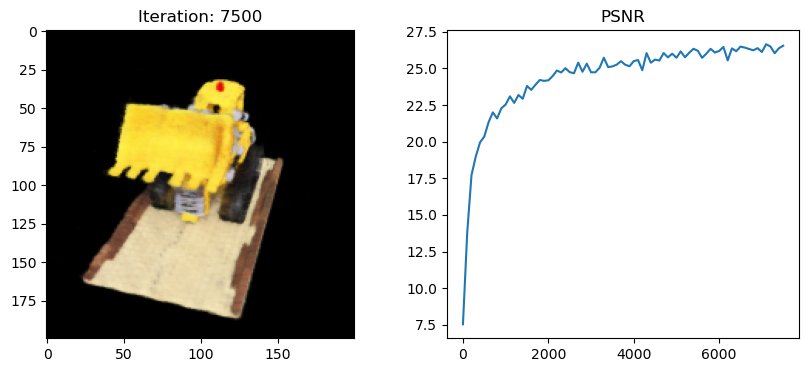

10000 0.06581873378753662 secs per iter
PSNR: 26.998272


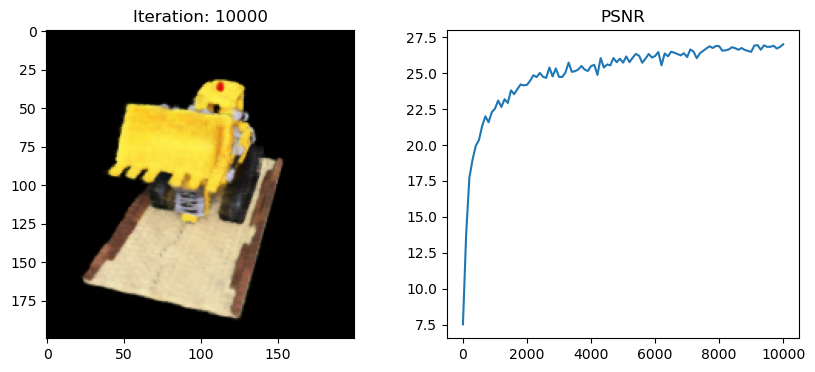

12500 0.06627642021179199 secs per iter
PSNR: 27.164436


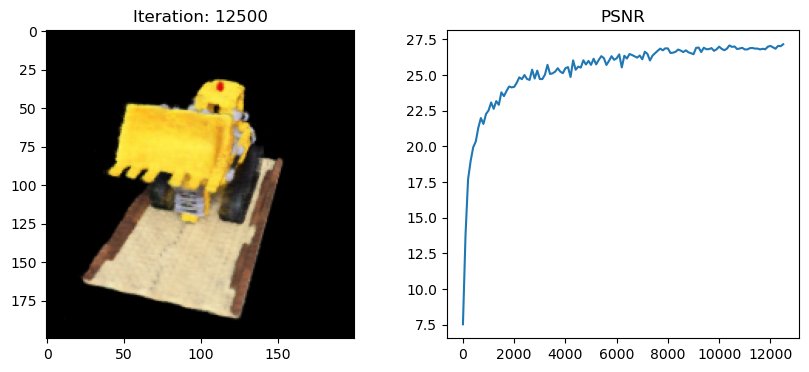

15000 0.06681275262832642 secs per iter
PSNR: 27.096884


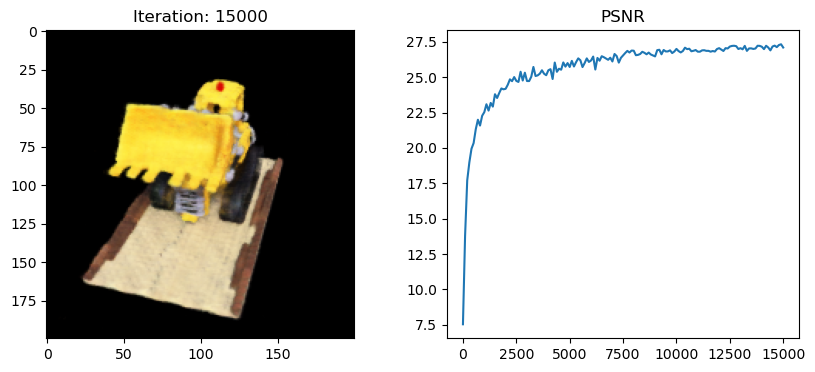

17500 0.0662095977783203 secs per iter
PSNR: 27.28807


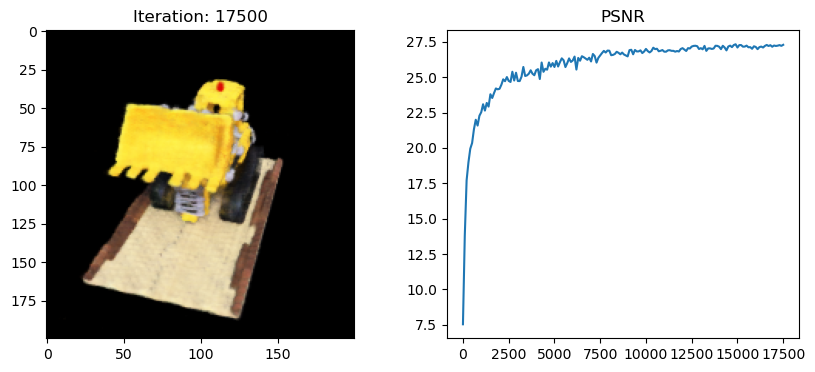

20000 0.06575879402160645 secs per iter
PSNR: 27.353714


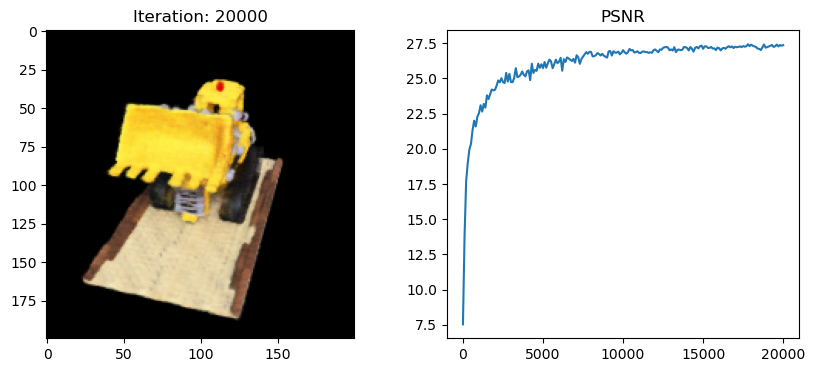

22500 0.06580253553390503 secs per iter
PSNR: 27.370153


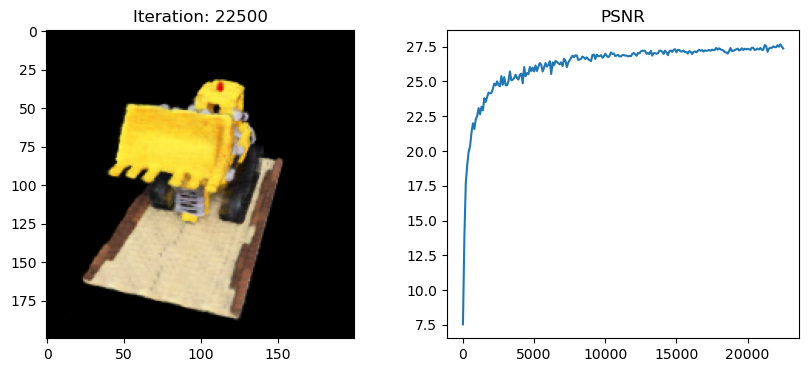

25000 0.06607560653686523 secs per iter
PSNR: 27.354748


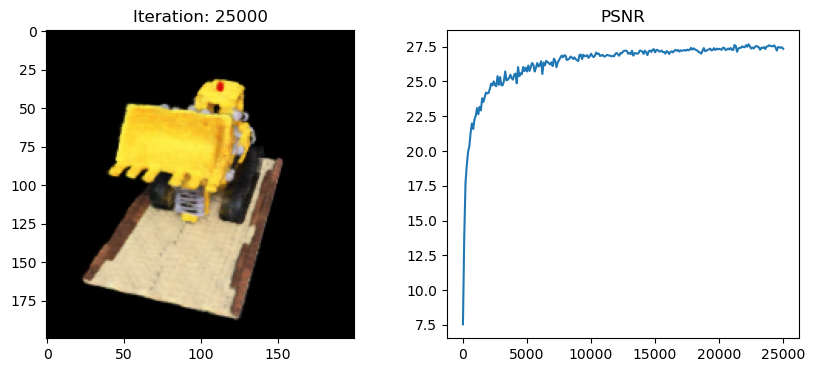

27500 0.06630918760299682 secs per iter
PSNR: 27.503708


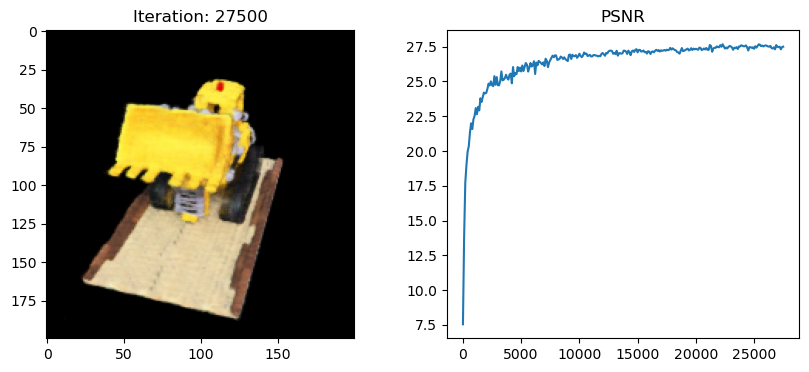

30000 0.06617293300628663 secs per iter
PSNR: 27.671423


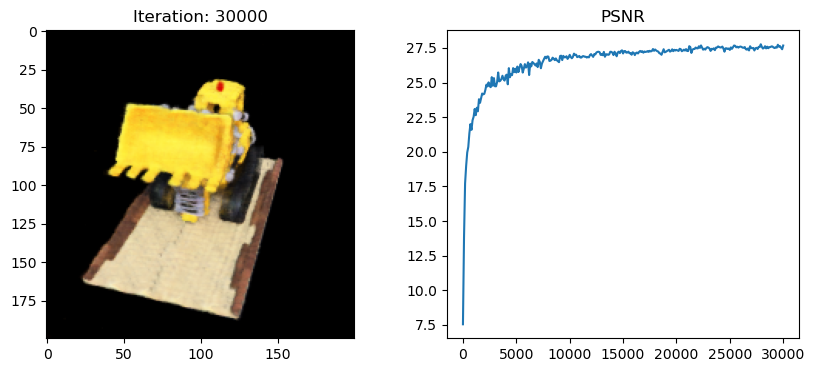

32500 0.06654568138122559 secs per iter
PSNR: 27.729654


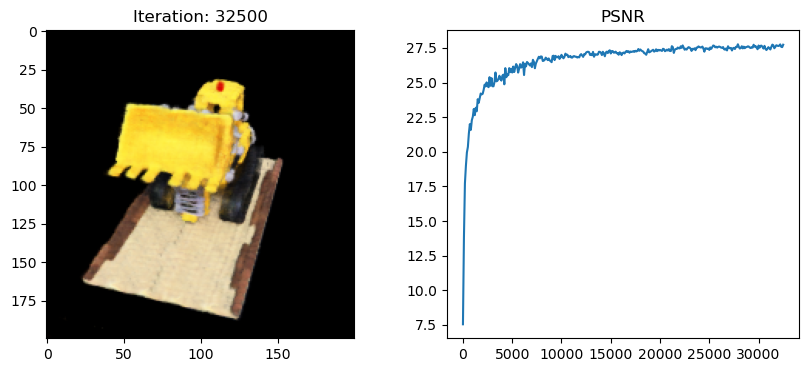

35000 0.06608703660964965 secs per iter
PSNR: 27.81534


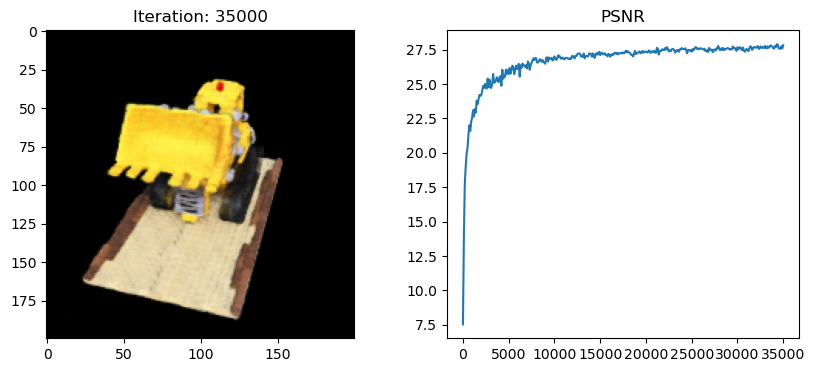

37500 0.06644299554824828 secs per iter
PSNR: 27.622587


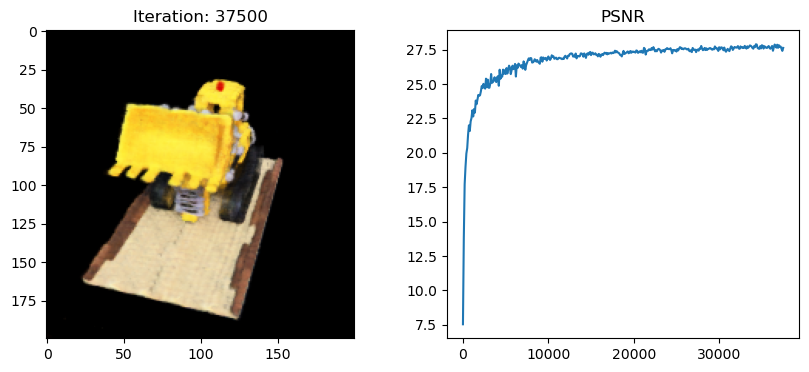

40000 0.06678436679840088 secs per iter
PSNR: 27.736944


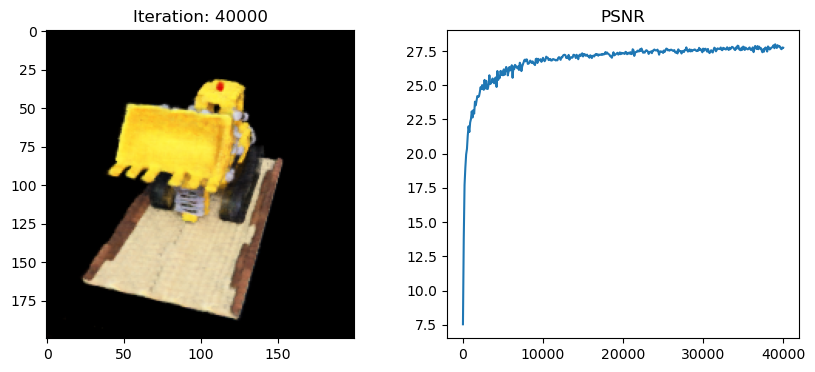

42500 0.06615818996429443 secs per iter
PSNR: 27.650896


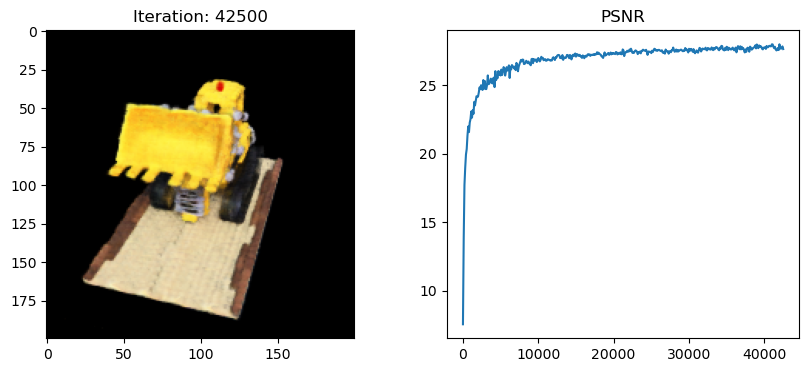

45000 0.06649115142822265 secs per iter
PSNR: 27.980484


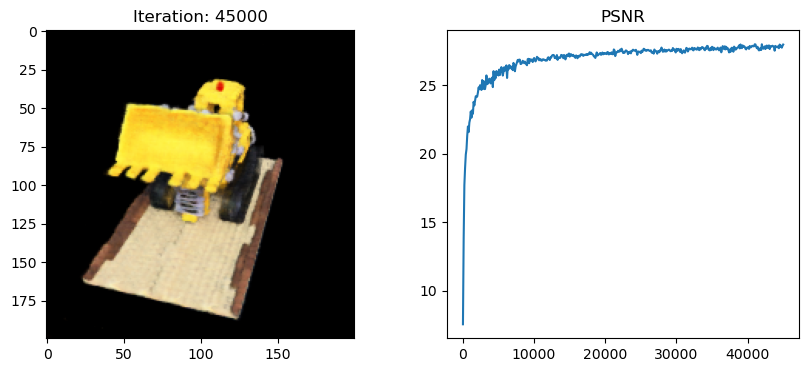

47500 0.0669992392539978 secs per iter
PSNR: 27.843409


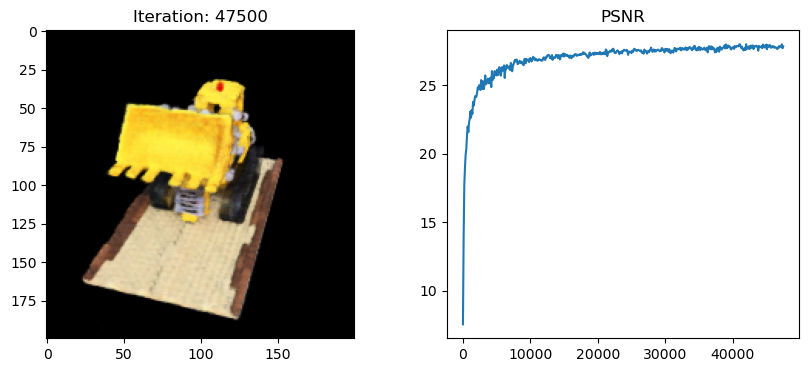

50000 0.06688221645355225 secs per iter
PSNR: 27.96771


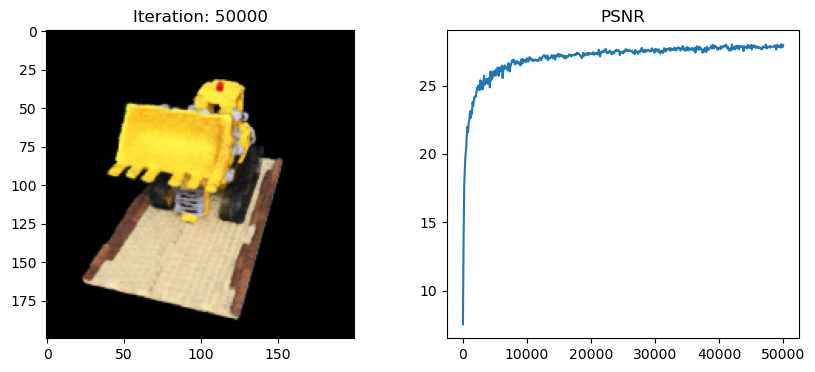

Done


In [ ]:
psnrs = []
iter_nums = []
t = time.time()
for i in range(N_iters + 1):
    img_idx = np.random.randint(images_train.shape[0])
    target_img = images_train[img_idx]
    pose = c2ws_train[img_idx]

    rays_o, rays_d = get_rays(H, W, focal, pose)
    ray_batch, target_batch = sample_random_rays(rays_o, rays_d, target_img, N_rand)
    rays_o_batch, rays_d_batch = ray_batch[0], ray_batch[1]

    with tf.GradientTape() as tape:
        rgb, extras = render((rays_o_batch, rays_d_batch), **kwargs)

        loss = tf.reduce_mean(tf.square(rgb - target_batch))
        if "rgb_map_coarse" in extras:
            loss += tf.reduce_mean(tf.square(extras["rgb_map_coarse"] - target_batch))

    grads = tape.gradient(loss, params)
    optimizer.apply_gradients(zip(grads, params))

    if i % i_test == 0:
        # Render the holdout view for logging
        rays_o_test, rays_d_test = get_rays(H, W, focal, test_pose)
        rgb_test, _ = render((rays_o_test, rays_d_test), **kwargs_test)  # Tuple

        test_loss = tf.reduce_mean(tf.square(rgb_test - test_img))
        psnr = -10.0 * tf.math.log(test_loss) / tf.math.log(10.0)
        psnrs.append(psnr.numpy())
        iter_nums.append(i)

    if i % i_display == 0:
        print(i, (time.time() - t) / i_display, "secs per iter")
        t = time.time()

        print("PSNR:", psnrs[-1])

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb_test)
        plt.title(f"Iteration: {i}")
        plt.subplot(122)
        plt.plot(iter_nums, psnrs)
        plt.title("PSNR")
        plt.show()

print("Done")

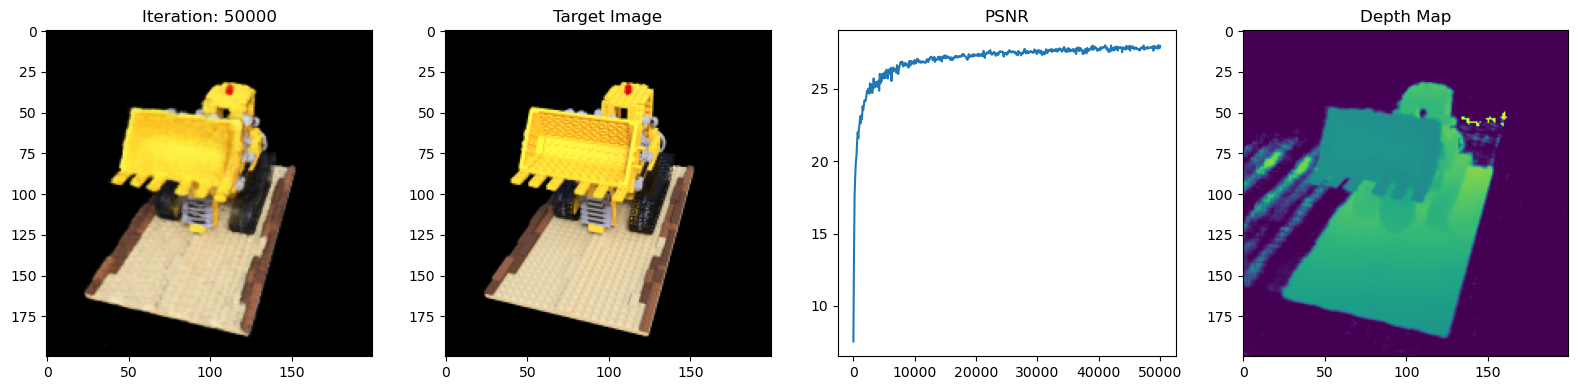

In [31]:
rays_o_final, rays_d_final = get_rays(H, W, focal, test_pose)
rgb_final, extras_final = render([rays_o_final, rays_d_final], **kwargs_test)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(rgb_final)
axes[0].set_title(f"Iteration: {N_iters}")

axes[1].imshow(test_img)
axes[1].set_title("Target Image")

axes[2].plot(iter_nums, psnrs)
axes[2].set_title(f"PSNR")

axes[3].imshow(extras_final["depth_map"], cmap="viridis")
axes[3].set_title("Depth Map")

plt.tight_layout()
plt.show()

In [33]:
model_coarse.save_weights(f"./checkpoints/nerf_coarse_stage1_{N_iters}iters.weights.h5")
if N_f > 0:
    model_fine.save_weights(f"./checkpoints/nerf_fine_stage1_{N_iters}iters.weights.h5")

## Finetuning

In [76]:
N_c = 128  # Coerse samples
N_f = 0  # Fine samples
N_iters = 10000  # Number of iterations
N_rand = 32 * 32 * 2  # Random rays per batch
chunk = 1024 * 32  # Number of rays per chunk
network_chunk = 1024 * 32  # Number of rays per chunk for network
i_test = 200  # Test every i_test iterations
i_display = 1000  # Display every i_display iterations

In [77]:
weight = "checkpoints/nerf_coarse_stage1_50000iters.weights.h5"
model_coarse.load_weights(weight)
model_fine.load_weights(weight)

In [78]:
params = model_coarse.trainable_variables
if N_f > 0:
    params += model_fine.trainable_variables

In [79]:
kwargs = {
    "network_coarse": model_coarse,
    "t_n": t_n,
    "t_f": t_f,
    "N_c": N_c,
    "chunk": chunk,
    "netchunk": network_chunk,
    "encode_pos_fn": encode_pos_fn,
    "encode_dir_fn": encode_dir_fn,
    "network_fine": model_fine,
    "N_f": N_f,
}

kwargs_test = {k: kwargs[k] for k in kwargs}
kwargs_test["perturb"] = False

In [80]:
initial_lr = 5e-4
lr_decay_steps = 10
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=lr_decay_steps * 1000,
    alpha=0.1,
)

In [81]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

50001 0.0007974588871002197 secs per iter
PSNR: 28.439117


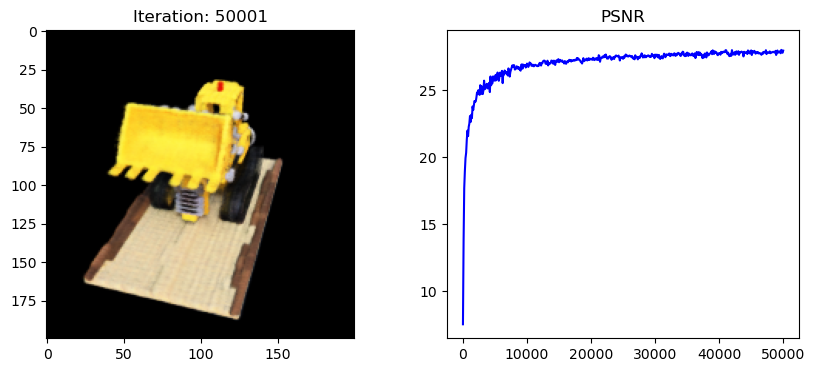

51000 0.10467095732688904 secs per iter
PSNR: 27.939497


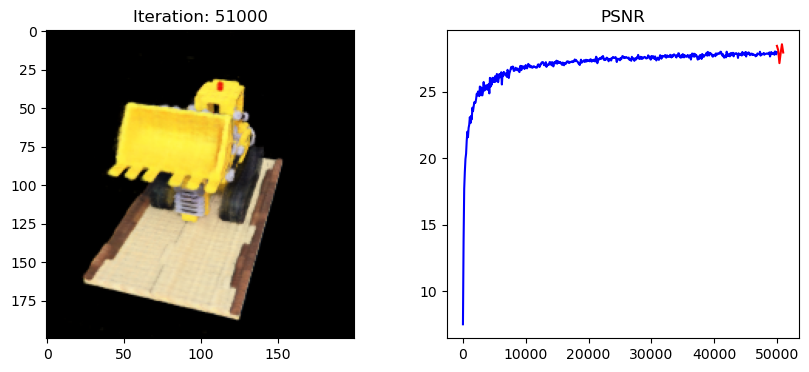

52000 0.10507606554031372 secs per iter
PSNR: 28.607197


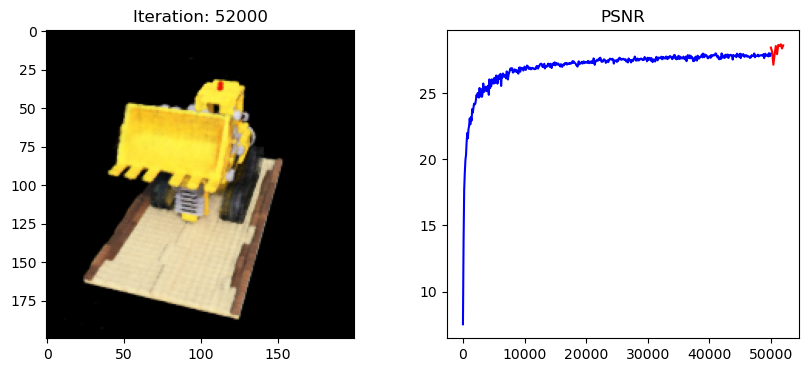

53000 0.10483754730224609 secs per iter
PSNR: 28.827333


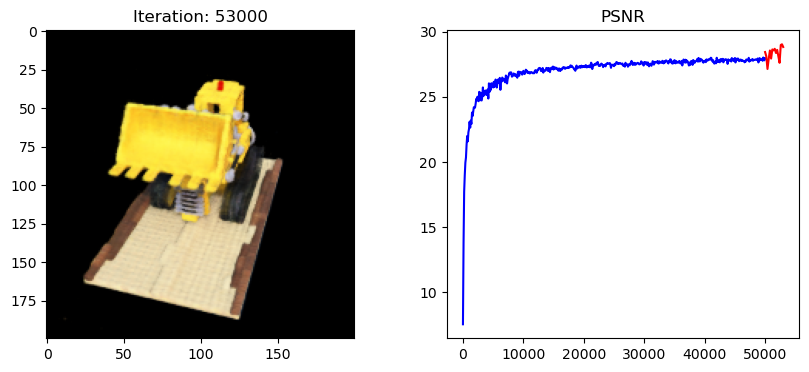

54000 0.10504752230644226 secs per iter
PSNR: 28.732595


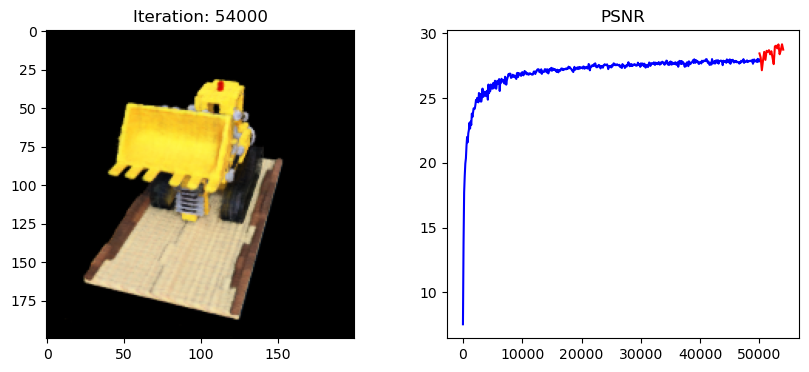

55000 0.1045777804851532 secs per iter
PSNR: 29.586739


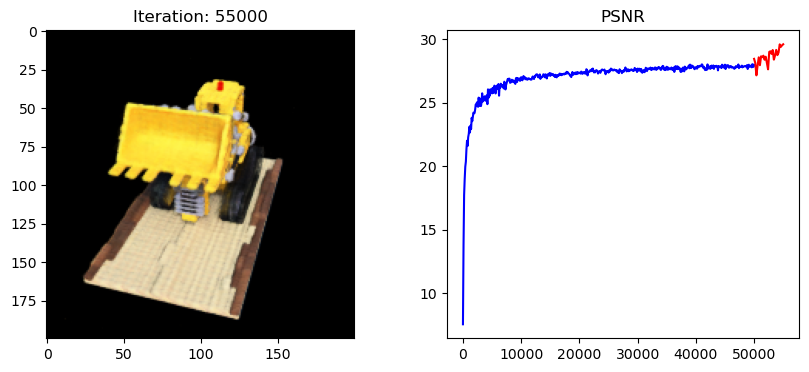

56000 0.10467417907714843 secs per iter
PSNR: 29.800346


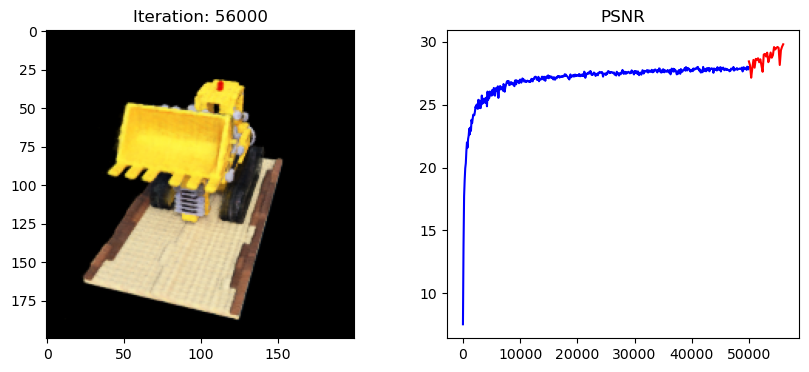

57000 0.10477621221542359 secs per iter
PSNR: 29.733604


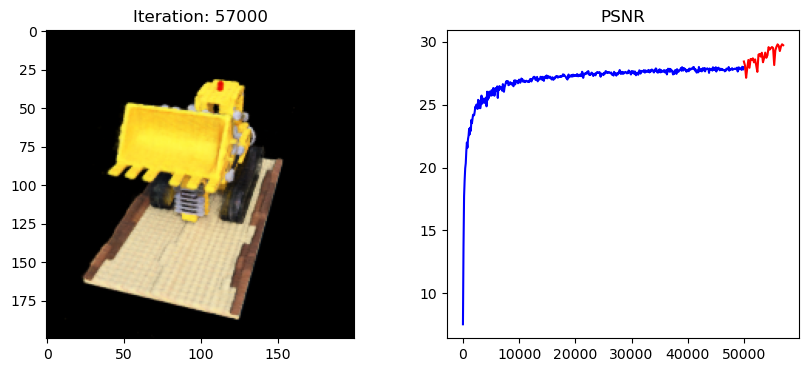

58000 0.10475337195396424 secs per iter
PSNR: 30.183308


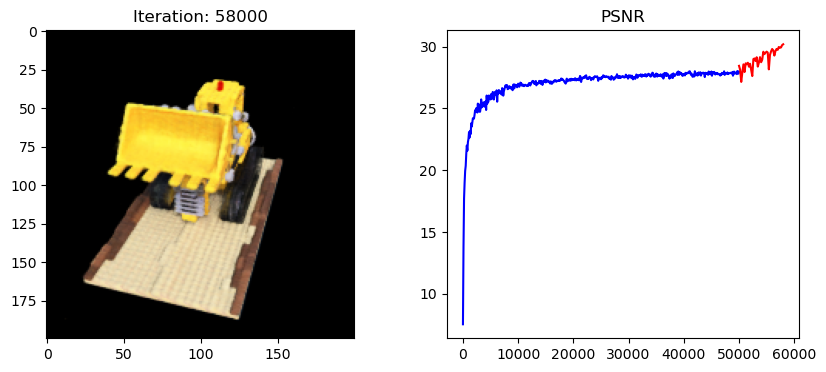

59000 0.10519914507865906 secs per iter
PSNR: 30.226736


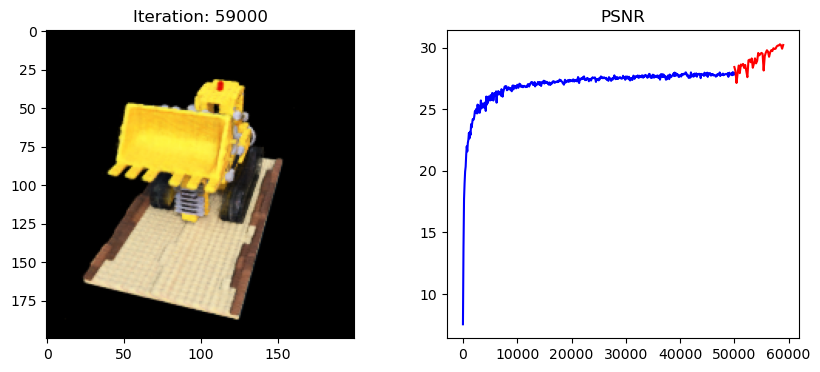

60000 0.10459865188598633 secs per iter
PSNR: 30.296993


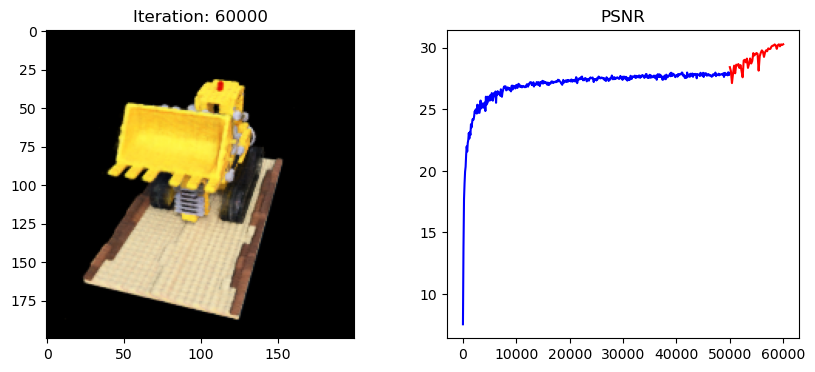

Done


In [82]:
t = time.time()
new_psnrs = []
new_iter_nums = []
start_iter = iter_nums[-1] + 1
for i in range(start_iter, start_iter + N_iters + 1):
    img_idx = np.random.randint(images_train.shape[0])
    target_img = images_train[img_idx]
    pose = c2ws_train[img_idx]

    rays_o, rays_d = get_rays(H, W, focal, pose)
    ray_batch, target_batch = sample_random_rays(rays_o, rays_d, target_img, N_rand)

    with tf.GradientTape() as tape:
        rgb, extras = render(ray_batch, **kwargs)

        loss = tf.reduce_mean(tf.square(rgb - target_batch))
        if "rgb_map_coarse" in extras:
            loss += tf.reduce_mean(tf.square(extras["rgb_map_coarse"] - target_batch))

    grads = tape.gradient(loss, params)
    optimizer.apply_gradients(zip(grads, params))

    if i % i_test == 0 or i == start_iter:
        # Render the holdout view for logging
        rays_o_test, rays_d_test = get_rays(H, W, focal, test_pose)
        rgb_test, _ = render([rays_o_test, rays_d_test], **kwargs_test)

        test_loss = tf.reduce_mean(tf.square(rgb_test - test_img))
        psnr = -10.0 * tf.math.log(test_loss) / tf.math.log(10.0)
        new_psnrs.append(psnr.numpy())
        new_iter_nums.append(i)

    if i % i_display == 0 or i == start_iter:
        print(i, (time.time() - t) / i_display, "secs per iter")
        t = time.time()

        print("PSNR:", new_psnrs[-1])

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb_test)
        plt.title(f"Iteration: {i}")
        plt.subplot(122)
        plt.plot(
            iter_nums,
            psnrs,
            "b",
        )
        plt.plot(new_iter_nums, new_psnrs, "r")
        plt.title("PSNR")
        plt.show()

print("Done")

In [86]:
model_coarse.save_weights(f"./checkpoints/nerf_coarse_stage2_{N_iters}iters.weights.h5")
if N_f > 0:
    model_fine.save_weights(f"./checkpoints/nerf_fine_stage2_{N_iters}iters.weights.h5")

## Final result

We defines 3D geometric transformations using homogeneous matrices, which combine translations and rotations into a single representation for rigid body motion:
- `T_z`: represents a translation along the $ z $-axis by a distance $ t $.
- `R_phi`: represents a rotation by an angle $ \phi $ around the $ x $-axis.
- `R_theta`: represents a rotation by an angle $ \theta $ around the $ y $-axis.

In [83]:
T_z = lambda t: tf.convert_to_tensor(
    [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ],
    dtype=tf.float32,
)

R_phi = lambda phi: tf.convert_to_tensor(
    [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ],
    dtype=tf.float32,
)

R_theta = lambda theta: tf.convert_to_tensor(
    [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ],
    dtype=tf.float32,
)

In [84]:
def pose_spherical(theta, phi, r):
    c2w = T_z(r)
    c2w = R_phi(phi / 180.0 * np.pi) @ c2w
    c2w = R_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w

This function generates frames by simulating a 360° camera rotation around a scene.

In [85]:
frames = []
for theta in tqdm(np.linspace(0.0, 360.0, 120, endpoint=False)):
    c2w = pose_spherical(theta, -30.0, 4.0)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])
    rgb_map, _ = render([rays_o, rays_d], **kwargs)
    frames.append((255 * np.clip(rgb_map, 0, 1)).astype(np.uint8))

100%|██████████| 120/120 [01:18<00:00,  1.53it/s]


In [87]:
frames_resized = [
    np.array(Image.fromarray(frame).resize((208, 208))) for frame in frames
]

In [ ]:
output_path = "output/nerf_render.mp4"
imageio.mimwrite(output_path, frames_resized, fps=30, codec="libx264")

In [89]:
display(Video(output_path, embed=True, width=300, height=300))